In [1]:
import os
import scipy.io.wavfile as wav
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from IPython.display import Audio
from scipy.fft import fft, ifft, fftfreq, rfft, rfftfreq
from scipy import signal

In [2]:
%matplotlib inline

In [3]:
# some global variables
filepath = '/home/lagvna/slncs/'
mp3_name = 'drilling.mp3'
wav_name = 'drilling.wav'
sample_frequency = 44100
chunk_size = 44100

In [4]:
# converting mp3 to mono wav
sound = AudioSegment.from_mp3(filepath + mp3_name)
sound = sound.set_channels(1)
sound.export(filepath + wav_name, format="wav")

<_io.BufferedRandom name='/home/lagvna/slncs/drilling.wav'>

# EDA

In [5]:
rate, data = wav.read('drilling.wav')

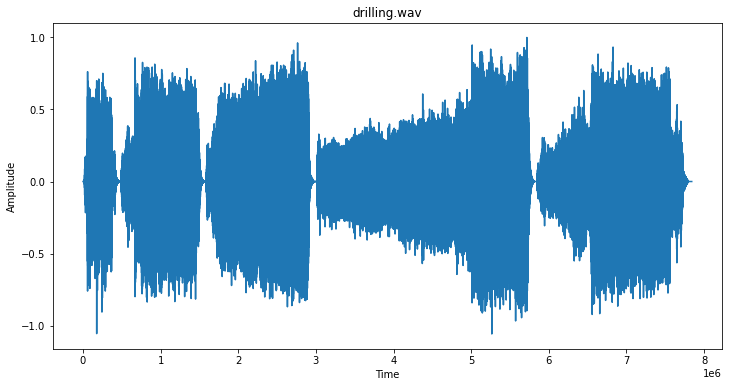

In [6]:
# plot the data
plt.figure(figsize=(12, 6))
plt.plot(data/np.max(data))
plt.title(wav_name)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [7]:
len(data)/rate

177.79045351473923

/home/lagvna/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


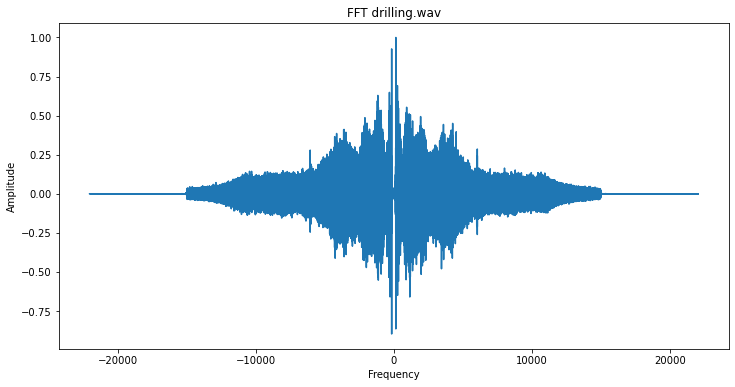

In [8]:
# fft
yf = fft(data)
yf = yf/np.max(yf)
xf = fftfreq(len(data), 1 / rate)

plt.figure(figsize=(12, 6))
plt.plot(xf, yf)
plt.title("FFT " + wav_name)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [9]:
len(data) / sample_frequency

177.79045351473923

In [10]:
# stft
f, t, Zxx = signal.stft(data, nperseg=512)

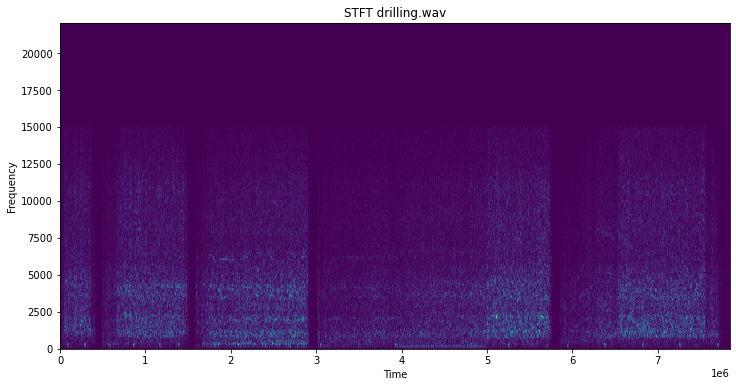

In [11]:
plt.figure(figsize=(12,6))
plt.pcolormesh(t, f*sample_frequency, np.abs(Zxx), vmin=0, shading='flat')
plt.title("STFT "+wav_name)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

# Data preprocessing

In [12]:
def divide_data(recording, chunk_size):
    remainder = len(recording) % chunk_size
    padding_size = chunk_size - remainder
    padding_vector = np.zeros(padding_size)
    padded_recording = np.append(recording, padding_vector)
    chunks = np.split(padded_recording, len(padded_recording)/chunk_size)
    
    return chunks

In [13]:
def fftransform(recording_chunks):
    fft_chunks = []
    for c in recording_chunks:
        fft_chunk = fft(c)
        full_fft_chunk = np.concatenate((np.real(fft_chunk), np.imag(fft_chunk)))
        fft_chunks.append(full_fft_chunk)
    return fft_chunks

In [14]:
def inv_fftransform(fq_chunks):
    chunks = []
    for c in fq_chunks:
        midpoint = c.shape[0] / 2
        real_chunk = c[0:int(midpoint)]
        imag_chunk = c[int(midpoint):]
        # amplitude represented as a complex number corresponding to the frequency
        full_chunk = real_chunk + 1.0j * imag_chunk
        time_chunk = ifft(full_chunk)
        chunks.append(time_chunk)
    return chunks

In [15]:
normalized_data = data / 32767.0
data_chunks = divide_data(normalized_data, chunk_size)
#print(data_chunks)
X = fftransform(data_chunks)
Y = fftransform(data_chunks[1:])
print(np.shape(X))
print(np.shape(Y))

(178, 88200)
(177, 88200)


#### LSTM requires a 3D input in the form of (samples, timesteps, features) ->
https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/

In [16]:
timestep = 20

In [17]:
# padding with zero vectors at the end, for an equal split
while len(X)%timestep != 0:
    X.append(np.zeros(np.shape(X)[1]))
    
while len(Y)%timestep != 0:
    Y.append(np.zeros(np.shape(Y)[1]))

In [18]:
# turning into np array to split examples equally into timesteps, then going back to a list
X = np.array(X)
tmp_x = np.split(X, X.shape[0]/timestep)
x_train = np.stack(tmp_x, axis = 0)

Y = np.array(Y)
tmp_y = np.split(Y, Y.shape[0]/timestep)
y_train = np.stack(tmp_y, axis = 0)

In [19]:
print(np.shape(x_train))
print(np.shape(y_train))

(9, 20, 88200)
(9, 20, 88200)


# Model design and training

In [20]:
NL = 1024

num_frequency_dimensions = (np.shape(X))[1]
a = (np.shape(x_train))[0]
b = (np.shape(x_train))[1]

model = Sequential()
model.add(TimeDistributed(Dense(NL, input_shape=(num_frequency_dimensions, ))))
model.add(Bidirectional(LSTM(NL, input_shape=(NL, ), return_sequences=True)))
#model.add(Bidirectional(LSTM(NL, input_shape=(NL, ), return_sequences=True)))
#model.add(Bidirectional(LSTM(NL, input_shape=(NL, ), return_sequences=True)))
model.add(TimeDistributed(Dense(num_frequency_dimensions, input_shape=(NL, ))))
#adam = Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
model.build((a, b, num_frequency_dimensions))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (9, 20, 1024)             90317824  
_________________________________________________________________
bidirectional (Bidirectional (9, 20, 2048)             16785408  
_________________________________________________________________
time_distributed_1 (TimeDist (9, 20, 88200)            180721800 
Total params: 287,825,032
Trainable params: 287,825,032
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(x_train, y_train, batch_size=10, epochs=1000, verbose=1, validation_split=0.0)

Epoch 1/1000
1/1 [==============================] - 12s 12s/step - loss: 360.4761
Epoch 2/1000
1/1 [==============================] - 5s 5s/step - loss: 360.3667
Epoch 3/1000
1/1 [==============================] - 5s 5s/step - loss: 359.9310
Epoch 4/1000
1/1 [==============================] - 5s 5s/step - loss: 359.4179
Epoch 5/1000
1/1 [==============================] - 5s 5s/step - loss: 358.8405
Epoch 6/1000
1/1 [==============================] - 4s 4s/step - loss: 358.2390
Epoch 7/1000
1/1 [==============================] - 5s 5s/step - loss: 357.6208
Epoch 8/1000
1/1 [==============================] - 5s 5s/step - loss: 356.9786
Epoch 9/1000
1/1 [==============================] - 5s 5s/step - loss: 356.2930
Epoch 10/1000
1/1 [==============================] - 5s 5s/step - loss: 355.5743
Epoch 11/1000
1/1 [==============================] - 4s 4s/step - loss: 354.8454
Epoch 12/1000
1/1 [==============================] - 5s 5s/step - loss: 354.1250
Epoch 13/1000
1/1 [================

1/1 [==============================] - 4s 4s/step - loss: 275.1264
Epoch 103/1000
1/1 [==============================] - 4s 4s/step - loss: 274.3133
Epoch 104/1000
1/1 [==============================] - 4s 4s/step - loss: 273.5195
Epoch 105/1000
1/1 [==============================] - 5s 5s/step - loss: 272.7035
Epoch 106/1000
1/1 [==============================] - 4s 4s/step - loss: 271.8548
Epoch 107/1000
1/1 [==============================] - 4s 4s/step - loss: 271.1301
Epoch 108/1000
1/1 [==============================] - 5s 5s/step - loss: 270.4534
Epoch 109/1000
1/1 [==============================] - 4s 4s/step - loss: 269.6963
Epoch 110/1000
1/1 [==============================] - 4s 4s/step - loss: 268.9452
Epoch 111/1000
1/1 [==============================] - 4s 4s/step - loss: 268.1300
Epoch 112/1000
1/1 [==============================] - 5s 5s/step - loss: 267.4035
Epoch 113/1000
1/1 [==============================] - 4s 4s/step - loss: 266.7496
Epoch 114/1000
1/1 [===========

1/1 [==============================] - 4s 4s/step - loss: 215.5418
Epoch 203/1000
1/1 [==============================] - 4s 4s/step - loss: 215.0290
Epoch 204/1000
1/1 [==============================] - 4s 4s/step - loss: 214.5255
Epoch 205/1000
1/1 [==============================] - 5s 5s/step - loss: 214.1179
Epoch 206/1000
1/1 [==============================] - 4s 4s/step - loss: 213.6961
Epoch 207/1000
1/1 [==============================] - 5s 5s/step - loss: 213.1413
Epoch 208/1000
1/1 [==============================] - 5s 5s/step - loss: 212.5689
Epoch 209/1000
1/1 [==============================] - 4s 4s/step - loss: 211.9725
Epoch 210/1000
1/1 [==============================] - 4s 4s/step - loss: 211.4891
Epoch 211/1000
1/1 [==============================] - 4s 4s/step - loss: 211.0875
Epoch 212/1000
1/1 [==============================] - 5s 5s/step - loss: 210.5773
Epoch 213/1000
1/1 [==============================] - 4s 4s/step - loss: 210.1374
Epoch 214/1000
1/1 [===========

1/1 [==============================] - 4s 4s/step - loss: 176.1015
Epoch 303/1000
1/1 [==============================] - 4s 4s/step - loss: 175.7622
Epoch 304/1000
1/1 [==============================] - 4s 4s/step - loss: 175.5604
Epoch 305/1000
1/1 [==============================] - 4s 4s/step - loss: 175.3446
Epoch 306/1000
1/1 [==============================] - 4s 4s/step - loss: 175.0199
Epoch 307/1000
1/1 [==============================] - 4s 4s/step - loss: 174.8271
Epoch 308/1000
1/1 [==============================] - 4s 4s/step - loss: 174.5864
Epoch 309/1000
1/1 [==============================] - 4s 4s/step - loss: 174.1755
Epoch 310/1000
1/1 [==============================] - 4s 4s/step - loss: 173.9253
Epoch 311/1000
1/1 [==============================] - 4s 4s/step - loss: 173.6219
Epoch 312/1000
1/1 [==============================] - 4s 4s/step - loss: 173.3448
Epoch 313/1000
1/1 [==============================] - 4s 4s/step - loss: 173.1288
Epoch 314/1000
1/1 [===========

1/1 [==============================] - 4s 4s/step - loss: 145.9968
Epoch 403/1000
1/1 [==============================] - 4s 4s/step - loss: 145.6510
Epoch 404/1000
1/1 [==============================] - 4s 4s/step - loss: 145.4153
Epoch 405/1000
1/1 [==============================] - 4s 4s/step - loss: 145.2774
Epoch 406/1000
1/1 [==============================] - 4s 4s/step - loss: 145.1669
Epoch 407/1000
1/1 [==============================] - 4s 4s/step - loss: 145.0043
Epoch 408/1000
1/1 [==============================] - 4s 4s/step - loss: 144.6855
Epoch 409/1000
1/1 [==============================] - 4s 4s/step - loss: 144.3994
Epoch 410/1000
1/1 [==============================] - 4s 4s/step - loss: 144.1798
Epoch 411/1000
1/1 [==============================] - 4s 4s/step - loss: 143.8748
Epoch 412/1000
1/1 [==============================] - 4s 4s/step - loss: 143.6120
Epoch 413/1000
1/1 [==============================] - 4s 4s/step - loss: 143.4745
Epoch 414/1000
1/1 [===========

1/1 [==============================] - 4s 4s/step - loss: 124.7229
Epoch 503/1000
1/1 [==============================] - 4s 4s/step - loss: 124.5702
Epoch 504/1000
1/1 [==============================] - 4s 4s/step - loss: 124.2076
Epoch 505/1000
1/1 [==============================] - 4s 4s/step - loss: 124.0529
Epoch 506/1000
1/1 [==============================] - 4s 4s/step - loss: 123.8532
Epoch 507/1000
1/1 [==============================] - 4s 4s/step - loss: 123.6212
Epoch 508/1000
1/1 [==============================] - 4s 4s/step - loss: 123.3884
Epoch 509/1000
1/1 [==============================] - 4s 4s/step - loss: 123.1585
Epoch 510/1000
1/1 [==============================] - 4s 4s/step - loss: 123.0452
Epoch 511/1000
1/1 [==============================] - 4s 4s/step - loss: 122.7709
Epoch 512/1000
1/1 [==============================] - 4s 4s/step - loss: 122.5630
Epoch 513/1000
1/1 [==============================] - 4s 4s/step - loss: 122.2813
Epoch 514/1000
1/1 [===========

1/1 [==============================] - 4s 4s/step - loss: 107.8795
Epoch 603/1000
1/1 [==============================] - 4s 4s/step - loss: 107.5749
Epoch 604/1000
1/1 [==============================] - 4s 4s/step - loss: 107.3682
Epoch 605/1000
1/1 [==============================] - 4s 4s/step - loss: 107.0659
Epoch 606/1000
1/1 [==============================] - 4s 4s/step - loss: 106.6937
Epoch 607/1000
1/1 [==============================] - 4s 4s/step - loss: 106.5606
Epoch 608/1000
1/1 [==============================] - 4s 4s/step - loss: 106.3860
Epoch 609/1000
1/1 [==============================] - 4s 4s/step - loss: 106.1129
Epoch 610/1000
1/1 [==============================] - 4s 4s/step - loss: 105.8885
Epoch 611/1000
1/1 [==============================] - 4s 4s/step - loss: 105.8642
Epoch 612/1000
1/1 [==============================] - 4s 4s/step - loss: 105.7714
Epoch 613/1000
1/1 [==============================] - 4s 4s/step - loss: 105.6372
Epoch 614/1000
1/1 [===========

1/1 [==============================] - 6s 6s/step - loss: 97.2844
Epoch 703/1000
1/1 [==============================] - 5s 5s/step - loss: 97.1338
Epoch 704/1000
1/1 [==============================] - 5s 5s/step - loss: 96.9163
Epoch 705/1000
1/1 [==============================] - 5s 5s/step - loss: 96.8020
Epoch 706/1000
1/1 [==============================] - 5s 5s/step - loss: 96.5936
Epoch 707/1000
1/1 [==============================] - 5s 5s/step - loss: 96.4467
Epoch 708/1000
1/1 [==============================] - 5s 5s/step - loss: 96.2027
Epoch 709/1000
1/1 [==============================] - 6s 6s/step - loss: 96.0940
Epoch 710/1000
1/1 [==============================] - 5s 5s/step - loss: 95.9301
Epoch 711/1000
1/1 [==============================] - 6s 6s/step - loss: 95.9153
Epoch 712/1000
1/1 [==============================] - 5s 5s/step - loss: 95.6687
Epoch 713/1000
1/1 [==============================] - 5s 5s/step - loss: 95.5760
Epoch 714/1000
1/1 [=======================

1/1 [==============================] - 5s 5s/step - loss: 82.4498
Epoch 804/1000
1/1 [==============================] - 4s 4s/step - loss: 82.1715
Epoch 805/1000
1/1 [==============================] - 4s 4s/step - loss: 82.0552
Epoch 806/1000
1/1 [==============================] - 5s 5s/step - loss: 81.9836
Epoch 807/1000
1/1 [==============================] - 5s 5s/step - loss: 81.6907
Epoch 808/1000
1/1 [==============================] - 5s 5s/step - loss: 81.5710
Epoch 809/1000
1/1 [==============================] - 5s 5s/step - loss: 81.5310
Epoch 810/1000
1/1 [==============================] - 4s 4s/step - loss: 81.4641
Epoch 811/1000
1/1 [==============================] - 4s 4s/step - loss: 81.4147
Epoch 812/1000
1/1 [==============================] - 4s 4s/step - loss: 81.3328
Epoch 813/1000
1/1 [==============================] - 4s 4s/step - loss: 81.3671
Epoch 814/1000
1/1 [==============================] - 4s 4s/step - loss: 81.1859
Epoch 815/1000
1/1 [=======================

1/1 [==============================] - 4s 4s/step - loss: 73.4067
Epoch 905/1000
1/1 [==============================] - 4s 4s/step - loss: 73.5639
Epoch 906/1000
1/1 [==============================] - 4s 4s/step - loss: 73.6338
Epoch 907/1000
1/1 [==============================] - 4s 4s/step - loss: 73.7396
Epoch 908/1000
1/1 [==============================] - 4s 4s/step - loss: 73.8173
Epoch 909/1000
1/1 [==============================] - 4s 4s/step - loss: 73.7133
Epoch 910/1000
1/1 [==============================] - 5s 5s/step - loss: 73.7668
Epoch 911/1000
1/1 [==============================] - 5s 5s/step - loss: 73.6991
Epoch 912/1000
1/1 [==============================] - 4s 4s/step - loss: 73.5522
Epoch 913/1000
1/1 [==============================] - 4s 4s/step - loss: 73.4098
Epoch 914/1000
1/1 [==============================] - 4s 4s/step - loss: 73.1236
Epoch 915/1000
1/1 [==============================] - 4s 4s/step - loss: 73.0137
Epoch 916/1000
1/1 [=======================

# Audio generation

In [42]:
# tak to trzeba zrobic - nie jeden timestep tylko caly blok i podobnie trzeba dopasowac nowy seed
seed = x_train[0]
gen_length = 3
# 1 sample with a no of timesteps and corresponding no of features
seed = np.reshape(seed, (1, seed.shape[0], seed.shape[1]))
#print(seed.shape)

output = []
for i in range(gen_length):
    generated_piece = model.predict(seed)
    #print(np.shape(generated_piece))
    #if i == 0:
    for j in range(generated_piece.shape[1]):
        output.append(generated_piece[0][j].copy())
        #print(np.shape(output))
    #else:
#         #print(gen_piece[0][gen_piece.shape[1]-1])
#         output.append(generated_piece[0][generated_piece.shape[1]-1].copy())
#         print(np.shape(output))

    print(np.shape(seed))
    new_seed = generated_piece[0][generated_piece.shape[1]-1]
    new_seed = np.reshape(new_seed, (1, 1, new_seed.shape[0]))
    seed = np.concatenate((seed, new_seed), axis=1)
    #print(np.shape(seed))
#print(output)

(1, 20, 88200)
(1, 21, 88200)
(1, 22, 88200)


In [39]:
gen_file_path = '/home/lagvna/slncs/gen_sound.wav'
inv_output = inv_fftransform(output)
print(np.shape(output))
gen_file = np.concatenate(inv_output)
final_file = gen_file * 32767.0
final_file = final_file.astype('int16')
wav.write(gen_file_path, sample_frequency, final_file)

(63, 88200)


<ipython-input-39-77d1b581b38d>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  final_file = final_file.astype('int16')


In [41]:
Audio(gen_file_path)